This notebook contains code to perform annotation enrichment using Fisher's exact test

In [282]:
import scipy.stats as stats
import pandas as pd
import sys
sys.path.append("/storage/BonnieH/selection_project/helper_functions")
from Joint_method_functions import *
import matplotlib.pyplot as plt
import numpy as np
import math

In [283]:
# Key: label, Value: (odds ratio, p value)
CEU_YRI_dic = {}
CEU_CHB_dic = {}
YRI_CHB_dic = {}

In [284]:
CEU_YRI_df = pd.read_csv('diff_scores_CEU_YRI_annot.txt', sep='\t')# names = ['chrom','start','CEU_s_val','YRI_s_val','CEU_95%_CI','YRI_95%_CI','CEU_p_val','YRI_p_val','diff_score_med','diff_selection'])
CEU_CHB_df = pd.read_csv('diff_scores_CEU_CHB_annot.txt', sep='\t')
YRI_CHB_df = pd.read_csv('diff_scores_YRI_CHB_annot.txt', sep='\t')

In [285]:
# Initial information processing
# Saves test and background files for use with the GREAT tool
def info_processing(df, pop1, pop2):
    df_diff_sel = df.loc[df['diff_selection'] == 'Y']
    if pop1 == 'YRI':
        df_diff_sel = df_diff_sel.loc[df_diff_sel[pop2 + '_s_val'] < df_diff_sel['YRI_s_val']]
    if pop2 == 'YRI':
        df_diff_sel = df_diff_sel.loc[df_diff_sel[pop1 + '_s_val'] < df_diff_sel['YRI_s_val']]
        
    df_both_sel = df.loc[df[pop1+'_p_val'] < 0.001]
    df_both_sel = df_both_sel.loc[df_both_sel[pop2+'_p_val'] < 0.001]

    # Write loci under differential selection to file
    chrom_list = []
    for elem in df_diff_sel['chrom']:
        chrom_list.append(str(elem))
    df = pd.DataFrame()
    df['chrom'] = chrom_list
    start_list = list(df_diff_sel['start'])
    df['start'] = start_list
    end_list = list(df_diff_sel['end'])
    df['end'] = end_list
    df.to_csv('./great/test_%s_%s.txt'%(pop1,pop2), sep = '\t', index=False)

    # Write loci under selection in at least one population to file
    chrom_list_at_least_one = []
    for elem in df_both_sel['chrom']:
        chrom_list_at_least_one.append(str(elem))
    df = pd.DataFrame()
    chrom_list.extend(chrom_list_at_least_one)
    df['chrom'] = chrom_list
    start_list.extend(list(df_both_sel['start']))
    df['start'] = start_list
    end_list.extend(list(df_both_sel['end']))
    df['end'] = end_list
    df.to_csv('./great/background_%s_%s.txt'%(pop1,pop2), sep = '\t', index=False)

    diff_sel = df_diff_sel.shape[0]
    both_sel = df_both_sel.shape[0]

    print(diff_sel)
    print(both_sel)
    
    return df_diff_sel, df_both_sel

In [286]:
def fishers_exact_test(df_diff_sel, df_both_sel, pop1, pop2, annot, equals, info_dic):
    #print('Annotation: ' + annot + ' ' + str(equals))
    #print('%s v %s'%(pop1,pop2))

    #if annot == 'motif':
        #all_motifs = GetCanonicalRU(eq, True)
        
        #CEU_YRI_coding_diff_sel = CEU_YRI_df_diff_sel.loc[CEU_YRI_df_diff_sel[annot] in all_motifs]
        #CEU_YRI_coding_both_sel = CEU_YRI_df_both_sel.loc[CEU_YRI_df_both_sel[annot] in all_motifs]
    #else:
        
    annot_df_diff_sel = df_diff_sel.loc[df_diff_sel[annot] == equals]
    annot_df_both_sel = df_both_sel.loc[df_both_sel[annot] == equals]
    
    diff_sel_annot = annot_df_diff_sel.shape[0]
    diff_sel_not_annot = df_diff_sel.shape[0] - annot_df_diff_sel.shape[0]
    both_sel_annot = annot_df_both_sel.shape[0] 
    both_sel_not_annot = df_both_sel.shape[0] - annot_df_both_sel.shape[0] 

    #oddsratio, pvalue,a,b = stats.chi2_contingency([[CEU_YRI_coding_diff_sel.shape[0], diff_sel_CEU_YRI - CEU_YRI_coding_diff_sel.shape[0]], [CEU_YRI_coding_both_sel.shape[0], both_sel_CEU_YRI - CEU_YRI_coding_both_sel.shape[0]]])
    oddsratio, pvalue = stats.fisher_exact([[diff_sel_annot, diff_sel_not_annot], [both_sel_annot, both_sel_not_annot]])
    
    
    df = pd.DataFrame()
    df['Differential_selection'] = [diff_sel_annot, diff_sel_not_annot]
    df['Both_under_selection'] = [both_sel_annot, both_sel_not_annot]
    df.index = [annot + ' ' + str(equals), 'not ' + annot + ' ' + str(equals)] 
    
    label = ''
    #if diff_sel_annot/diff_sel_not_annot < both_sel_annot/both_sel_not_annot:
        #label = 'not '
    if pvalue == 0:
        pvalue = 1*10^-200
    if pvalue < 0.05:
        if oddsratio == 0:
            print('weird')
        if annot == 'period' or annot == 'motif':
            info_dic[label + annot + ' ' + str(equals)] = (math.log(oddsratio,2), -1*np.log10(pvalue))
        else:
            info_dic[label + annot] = (math.log(oddsratio,2), -1*np.log10(pvalue))
    #print("Odds ratio: " + str(oddsratio))
    #print("Fisher's exact test pvalue: " + str(pvalue))
    #print(df)
    return df, pvalue, oddsratio

In [287]:
def run_fishers_test(annot, equals):
    fishers_exact_test(df_diff_sel_CEU_YRI, df_both_sel_CEU_YRI,  'CEU', 'YRI', annot, equals, CEU_YRI_dic)
    fishers_exact_test(df_diff_sel_CEU_CHB, df_both_sel_CEU_CHB,  'CEU', 'CHB', annot, equals, CEU_CHB_dic)
    fishers_exact_test(df_diff_sel_YRI_CHB, df_both_sel_YRI_CHB , 'YRI', 'CHB', annot, equals, YRI_CHB_dic)

In [288]:
def plot_p_val(info_dic,pop1,pop2):
    print(info_dic)
    print(len(info_dic))
    sort = dict(sorted(info_dic.items(), key=lambda item: abs(item[1][0]), reverse=False))
    x = []
    y = []
    for item in sort:
        x.append(item)
        y.append(sort[item][1])
    plt.figure(1)
    plt.barh(x,y)
    plt.xlabel('-log10 p value')
    plt.ylabel('Annotation')
    plt.title('%s v %s Enrichment Analysis'%(pop1,pop2))

In [289]:
def plot_odds_ratio(info_dic,pop1,pop2):
    print(info_dic)
    print(len(info_dic))
    sort = dict(sorted(info_dic.items(), key=lambda item: abs(item[1][0]), reverse=False))
    x = []
    y = []
    for item in sort:
        x.append(item)
        y.append(sort[item][0])
    plt.figure(1)
    plt.barh(x,y,color='black')
    plt.xlabel('log2 odds ratio')
    plt.ylabel('Annotation')
    plt.title('%s v %s Enrichment Analysis'%(pop1,pop2))

In [290]:
df_diff_sel_CEU_YRI, df_both_sel_CEU_YRI = info_processing(CEU_YRI_df, 'CEU', 'YRI')
df_diff_sel_CEU_CHB, df_both_sel_CEU_CHB = info_processing(CEU_CHB_df, 'CEU', 'CHB')
df_diff_sel_YRI_CHB, df_both_sel_YRI_CHB = info_processing(YRI_CHB_df, 'YRI', 'CHB')

96
4417
1036
7664
105
4460


In [291]:
motif_list = ['AC','AG','AT','ACC','AGG','AGC','CCG','AAG','AAC','ATC','AAT','AAGG','AAAT','ATCC','AATC','AAAC','AATG','ACAT','AGAT','AAAG']
pers = [2,3,4]
gene_annotations = ['coding','intron','utr5','utr3','promoter','intergenic']

In [292]:
for motif in motif_list:
    run_fishers_test('motif',motif)
for per in pers:
    run_fishers_test('period',per)
for annot in gene_annotations:
    run_fishers_test(annot,1.0)

{'motif AC': (3.3100066761235762, 13.128115181745915), 'motif AAT': (-3.1374233539829786, 23.508805066535853), 'motif AAAT': (1.7732266340196927, 3.8287811931258044), 'motif AAAC': (2.489672392245227, 3.274424391570662), 'motif ACAT': (2.1902974758998432, 1.4599348182555008), 'motif AGAT': (1.3977276141587627, 1.4587636562379482), 'period 2': (3.2466273366432774, 13.70932742479795), 'period 3': (-3.1713379636538837, 23.830119692135778), 'period 4': (2.052924422545861, 8.987175353506162), 'utr5': (5.538668848447221, 1.375760368490306)}
10


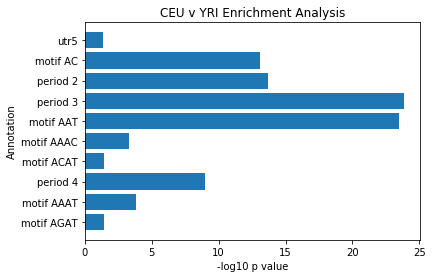

In [293]:
plot_p_val(CEU_YRI_dic,'CEU','YRI')

{'motif AC': (2.5962114522748387, 147.48710744908058), 'motif AG': (2.066571343104866, 2.7943626748123918), 'motif AT': (2.136417132191077, 15.149895423008163), 'motif AAC': (0.5809253742465428, 1.4240676624560398), 'motif AAT': (-3.4833806074891025, 196.63310742290463), 'motif AAGG': (1.8921695683003874, 1.5918855358869355), 'motif AAAT': (0.6218792087290306, 4.393858419816077), 'motif ATCC': (-2.391493188625441, 2.3153071772401286), 'motif AATG': (-1.2256053093669377, 1.4392524914697642), 'period 2': (2.8484090830146425, 178.83313854664445), 'period 3': (-3.135178561081455, 182.2996440905344)}
11


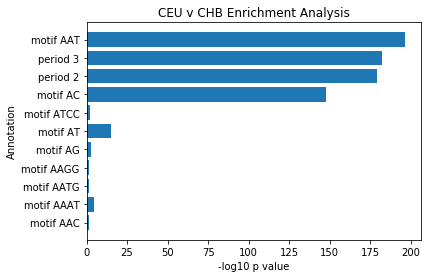

In [294]:
plot_p_val(CEU_CHB_dic,'CEU','CHB')

{'motif AC': (2.9191248310756763, 10.638712596307053), 'motif AT': (3.4724877714627436, 3.6665807209659835), 'motif AAT': (-2.75633327328486, 20.112215935301933), 'motif AAAT': (1.3257708621232918, 2.1525365743552114), 'motif AGAT': (2.2281366970819567, 3.797813437576547), 'period 2': (3.109309719056895, 13.83116028065738), 'period 3': (-2.8740612712798153, 21.46043155193128), 'period 4': (1.797031478788843, 7.303326710715293)}
8


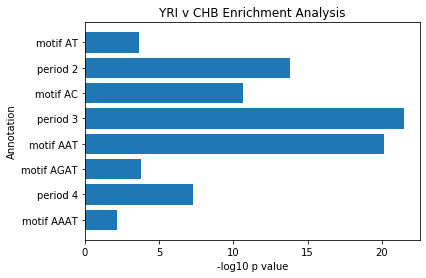

In [295]:
plot_p_val(YRI_CHB_dic,'YRI','CHB')

{'motif AC': (3.3100066761235762, 13.128115181745915), 'motif AAT': (-3.1374233539829786, 23.508805066535853), 'motif AAAT': (1.7732266340196927, 3.8287811931258044), 'motif AAAC': (2.489672392245227, 3.274424391570662), 'motif ACAT': (2.1902974758998432, 1.4599348182555008), 'motif AGAT': (1.3977276141587627, 1.4587636562379482), 'period 2': (3.2466273366432774, 13.70932742479795), 'period 3': (-3.1713379636538837, 23.830119692135778), 'period 4': (2.052924422545861, 8.987175353506162), 'utr5': (5.538668848447221, 1.375760368490306)}
10


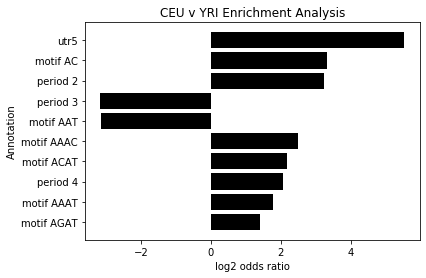

In [296]:
plot_odds_ratio(CEU_YRI_dic,'CEU','YRI')

{'motif AC': (2.5962114522748387, 147.48710744908058), 'motif AG': (2.066571343104866, 2.7943626748123918), 'motif AT': (2.136417132191077, 15.149895423008163), 'motif AAC': (0.5809253742465428, 1.4240676624560398), 'motif AAT': (-3.4833806074891025, 196.63310742290463), 'motif AAGG': (1.8921695683003874, 1.5918855358869355), 'motif AAAT': (0.6218792087290306, 4.393858419816077), 'motif ATCC': (-2.391493188625441, 2.3153071772401286), 'motif AATG': (-1.2256053093669377, 1.4392524914697642), 'period 2': (2.8484090830146425, 178.83313854664445), 'period 3': (-3.135178561081455, 182.2996440905344)}
11


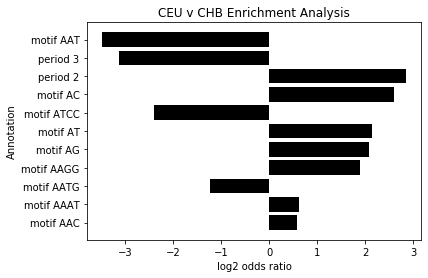

In [297]:
plot_odds_ratio(CEU_CHB_dic,'CEU','CHB')

{'motif AC': (2.9191248310756763, 10.638712596307053), 'motif AT': (3.4724877714627436, 3.6665807209659835), 'motif AAT': (-2.75633327328486, 20.112215935301933), 'motif AAAT': (1.3257708621232918, 2.1525365743552114), 'motif AGAT': (2.2281366970819567, 3.797813437576547), 'period 2': (3.109309719056895, 13.83116028065738), 'period 3': (-2.8740612712798153, 21.46043155193128), 'period 4': (1.797031478788843, 7.303326710715293)}
8


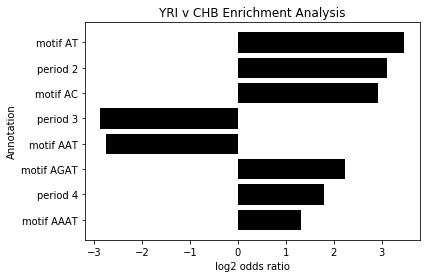

In [298]:
plot_odds_ratio(YRI_CHB_dic,'YRI','CHB')